In [1]:
from pm4py.objects.log.importer.xes import importer as xes_importer
variant = xes_importer.Variants.ITERPARSE
parameters = {variant.value.Parameters.TIMESTAMP_SORT: True,variant.value.Parameters.TIMESTAMP_KEY : 'time:timestamp'}
log = xes_importer.apply('Road_Traffic_Fine_Management_Process-Copy1.xes', variant = variant,
                         parameters=parameters)

parsing log, completed traces ::   0%|          | 0/150370 [00:00<?, ?it/s]

In [2]:
for event in log[0]:
    print(event)

{'amount': 62.59, 'org:resource': '18', 'dismissal': 'NIL', 'concept:name': 'Create Fine', 'vehicleClass': 'A', 'totalPaymentAmount': 0.0, 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2000, 1, 1, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'article': 158, 'points': 0}
{'concept:name': 'Send Fine', 'lifecycle:transition': 'complete', 'expense': 11.41, 'time:timestamp': datetime.datetime(2000, 4, 16, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}
{'notificationType': 'P', 'concept:name': 'Insert Fine Notification', 'lifecycle:transition': 'complete', 'lastSent': 'N', 'time:timestamp': datetime.datetime(2000, 5, 3, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}
{'amount': 125.19, 'concept:name': 'Add penalty', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2000, 7, 2, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}
{'concept:name': 'Send for Credit Collecti

In [3]:
import pm4py
strings = []
numerics = []
attributes_list = pm4py.get_event_attributes(log)
for a in attributes_list:
    attribute_values = pm4py.get_event_attribute_values(log, (a))
    type_v = type(list(attribute_values.keys())[0])
    sum_attr_values = sum(attribute_values.values())
    if type_v == str :
        strings.append(a)
    elif type_v == float or type_v == int:
        if sum_attr_values >= len(log):
            numerics.append(a)
#for attr in numerics:
    #attr_values = pm4py.get_event_attribute_values(log,attr)
    #if sum(attr_values.values()) < len(log):
        #numerics.remove(attr)
print(strings)
print(numerics)

['org:resource', 'dismissal', 'vehicleClass', 'concept:name', 'lastSent', 'notificationType']
['totalPaymentAmount', 'points', 'amount', 'article']


In [4]:
from pm4py.algo.transformation.log_to_features import algorithm as log_to_features

data, feature_names = log_to_features.apply(log, parameters={"str_ev_attr": strings, 
                    "str_tr_attr": [], "num_ev_attr": numerics, "num_tr_attr": [], "str_evsucc_attr": []})
print(len(feature_names))

200


In [5]:
import pandas as pd
df = pd.DataFrame(data, columns=feature_names)
df

,event:org:resource@0,event:org:resource@10,event:org:resource@11,event:org:resource@12,event:org:resource@13,event:org:resource@14,event:org:resource@15,event:org:resource@16,event:org:resource@17,event:org:resource@18,...,event:lastSent@N,event:lastSent@P,event:lastSent@UNDEFINED,event:notificationType@C,event:notificationType@P,event:notificationType@UNDEFINED,event:totalPaymentAmount,event:points,event:amount,event:article
0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0.00,0,125.19,158
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0.00,0,125.19,158
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,42.71,0,62.59,158
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0.00,0,62.59,158
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0.00,0,62.59,158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150365,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,41.00,0,41.00,7
150366,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,41.00,0,41.00,7
150367,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,41.00,0,41.00,7
150368,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,41.00,0,41.00,7


In [6]:
#for x in df.columns:
    #print(x)

In [7]:
columns = []
import re
r = '[\w\d\s:]+@UNDEFINED'
for x in df.columns:
    if re.search(r,x):
        columns.append(x)

print(columns)

['event:lastSent@UNDEFINED', 'event:notificationType@UNDEFINED']


In [8]:
df.drop(columns = columns, inplace = True)

In [9]:
for col in df.columns:
    for val in df[col].unique():
        if val != 1 and val != 0:
            print(col)
            break

event:totalPaymentAmount
event:points
event:amount
event:article


In [10]:
amount = pd.cut(df['event:amount'], 
                            bins=[0,0.00001,50,100,999,100000], 
                            labels=['Zero','Low', 'Medium', 'High', 'Really High'],
                            include_lowest = True)
totalpayment=pd.cut(df['event:totalPaymentAmount'], 
                            bins=[0,0.00001,50,100,999,100000], 
                            labels=['Zero','Low', 'Medium', 'High', 'Really High'],
                            include_lowest = True)
article = pd.cut(df['event:article'], 
                            bins=[0,0.00001,50,100,999,100000], 
                            labels=['Zero','Low', 'Medium', 'High', 'Really High'],
                            include_lowest = True)
points = pd.cut(df['event:points'],
                       bins = [0.0,0.00001,50,100,999,100000],
                       labels = ['Zero','Low', 'Medium', 'High', 'Really High'],
                        include_lowest = True)

In [11]:
df.drop(columns = ['event:article','event:totalPaymentAmount','event:points','event:amount'], inplace = True)

In [12]:
df['event:points'] = points
df['event:article'] =article
df['event:totalPaymentAmount'] = totalpayment
df['event:amount'] = amount

In [13]:
df = pd.get_dummies(data = df, columns = {'event:article','event:points','event:totalPaymentAmount','event:amount'},prefix_sep='@')

In [14]:
df.shape

(150370, 214)

In [15]:
columns = []
import re
r = 'event:concept:name@[\w\d\s:]+'
for x in df.columns:
    if re.search(r,x):
        columns.append(x)

print(columns)

['event:concept:name@Add penalty', 'event:concept:name@Appeal to Judge', 'event:concept:name@Create Fine', 'event:concept:name@Insert Date Appeal to Prefecture', 'event:concept:name@Insert Fine Notification', 'event:concept:name@Notify Result Appeal to Offender', 'event:concept:name@Payment', 'event:concept:name@Receive Result Appeal from Prefecture', 'event:concept:name@Send Appeal to Prefecture', 'event:concept:name@Send Fine', 'event:concept:name@Send for Credit Collection']


In [16]:
df.drop(columns = columns, inplace = True)

In [17]:
df.shape

(150370, 203)

In [18]:
df.mean().sort_values(ascending = False).head(20)

event:dismissal@NIL                0.996648
event:points@Zero                  0.976405
event:vehicleClass@A               0.975673
event:article@High                 0.703837
event:totalPaymentAmount@Zero      0.536384
event:notificationType@P           0.530199
event:amount@Low                   0.482151
event:amount@Medium                0.411438
event:totalPaymentAmount@Low       0.343280
event:lastSent@P                   0.309078
event:article@Low                  0.291454
event:lastSent@N                   0.201589
event:amount@High                  0.104043
event:totalPaymentAmount@Medium    0.099029
event:org:resource@538             0.057245
event:org:resource@550             0.052770
event:org:resource@541             0.048919
event:org:resource@537             0.046093
event:org:resource@559             0.042755
event:org:resource@557             0.036151
dtype: float64

In [19]:
for x in df.columns:
    if df[x].mean() > 0.95:
        df.drop(columns = [x], inplace = True)

In [20]:
from mlxtend.frequent_patterns import apriori
frequent_itemsets = apriori(df, min_support = 0.01,max_len = 3, use_colnames = True)

In [21]:
pd.set_option('display.max_colwidth', None)

In [22]:
frequent_itemsets.sort_values(by = 'support',ascending = False)

,support,itemsets
35,0.703837,(event:article@High)
30,0.536384,(event:totalPaymentAmount@Zero)
25,0.530199,(event:notificationType@P)
26,0.482151,(event:amount@Low)
27,0.411438,(event:amount@Medium)
...,...,...
105,0.010062,"(event:amount@Medium, event:org:resource@558)"
275,0.010049,"(event:amount@Medium, event:org:resource@558, event:notificationType@P)"
276,0.010042,"(event:org:resource@558, event:article@High, event:notificationType@P)"
273,0.010042,"(event:lastSent@P, event:org:resource@558, event:amount@Medium)"


In [23]:
type(frequent_itemsets)

pandas.core.frame.DataFrame

In [83]:
from mlxtend.frequent_patterns import association_rules
rules_mlxtend1 = association_rules(frequent_itemsets, metric="leverage", min_threshold=0.05)

In [25]:
pd.set_option('display.max_colwidth', None)

In [84]:
rules_mlxtend1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(event:notificationType@P),(event:lastSent@N),0.530199,0.201589,0.201137,0.379362,1.881854,0.094255,1.286435
1,(event:lastSent@N),(event:notificationType@P),0.201589,0.530199,0.201137,0.997757,1.881854,0.094255,209.427683
2,(event:amount@Medium),(event:lastSent@N),0.411438,0.201589,0.141664,0.344314,1.707995,0.058722,1.217672
3,(event:lastSent@N),(event:amount@Medium),0.201589,0.411438,0.141664,0.702735,1.707995,0.058722,1.979921
4,(event:totalPaymentAmount@Zero),(event:lastSent@N),0.536384,0.201589,0.163989,0.305731,1.516600,0.055860,1.150001
...,...,...,...,...,...,...,...,...,...
83,(event:amount@Low),"(event:article@High, event:totalPaymentAmount@Low)",0.482151,0.227379,0.202314,0.419608,1.845411,0.092683,1.331205
84,"(event:amount@Medium, event:article@High)",(event:totalPaymentAmount@Zero),0.318188,0.536384,0.224207,0.704636,1.313679,0.053536,1.569643
85,"(event:article@High, event:totalPaymentAmount@Zero)",(event:amount@Medium),0.384059,0.411438,0.224207,0.583782,1.418881,0.066190,1.414071
86,(event:amount@Medium),"(event:article@High, event:totalPaymentAmount@Zero)",0.411438,0.384059,0.224207,0.544934,1.418881,0.066190,1.353521


In [89]:
rules_mlxtend1.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,0.373454,0.371408,0.216417,0.629698,1.718850,0.089679,inf
std,0.123412,0.123588,0.066254,0.206570,0.217958,0.029159,NaN
min,0.113394,0.115894,0.107774,0.223528,1.313679,0.045272,1.138619
25%,0.299018,0.291508,0.163982,0.423280,1.519111,0.066167,1.332628
50%,0.377483,0.378274,0.220197,0.653182,1.780459,0.087317,1.649456
75%,0.495413,0.494163,0.278719,0.745219,1.883210,0.106997,2.172151
max,0.548884,0.536384,0.399714,1.000000,2.040420,0.162762,inf


In [86]:
antecedent_support = rules_mlxtend1['antecedent support'].to_numpy()
consequent_support = rules_mlxtend1['consequent support'].to_numpy()



In [77]:
support=rules_mlxtend1['support'].to_numpy()
confidence=rules_mlxtend1['confidence'].to_numpy()

In [87]:
lift=rules_mlxtend1['lift'].to_numpy()
leverage=rules_mlxtend1['leverage'].to_numpy()

### Support and Confidence

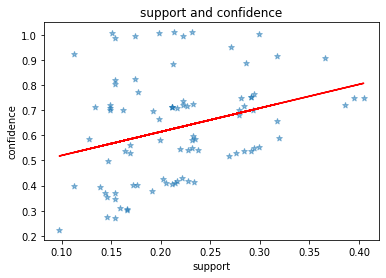

In [56]:
import numpy as np
import random
import matplotlib.pyplot as plt
 
for i in range (len(support)):
    support[i] = support[i] + 0.0025 * (random.randint(1,10) - 5) 
    confidence[i] = confidence[i] + 0.0025 * (random.randint(1,10) - 5)
plt.scatter(support, confidence,   alpha=0.5, marker="*")
plt.plot(support, np.poly1d(np.polyfit(support, confidence, 1))(support),'r')
plt.xlabel('support')
plt.ylabel('confidence') 
plt.title('support and confidence')
plt.show()
#https://intelligentonlinetools.com/blog/2018/02/10/how-to-create-data-visualization-for-association-rules-in-data-mining/

### Consequent Support and Confidence

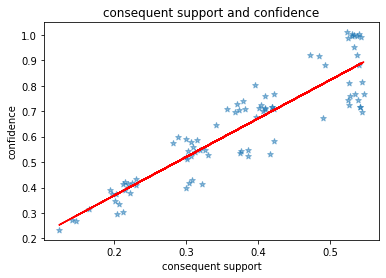

In [62]:
import random
import matplotlib.pyplot as plt
 
for i in range (len(consequent_support)):
    consequent_support[i] = consequent_support[i] + 0.0025 * (random.randint(1,10) - 5) 
    confidence[i] = confidence[i] + 0.0025 * (random.randint(1,10) - 5)
plt.scatter(consequent_support, confidence,   alpha=0.5, marker="*")
plt.plot(consequent_support, np.poly1d(np.polyfit(consequent_support, confidence, 1))(consequent_support),'r')
plt.xlabel('consequent support')
plt.ylabel('confidence') 
plt.title('consequent support and confidence')
plt.show()

### Antecedent support and confidence

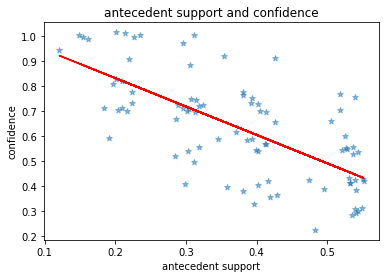

In [71]:
import random
import matplotlib.pyplot as plt
 
for i in range (len(antecedent_support)):
    antecedent_support[i] = antecedent_support[i] + 0.0025 * (random.randint(1,10) - 5) 
    confidence[i] = confidence[i] + 0.0025 * (random.randint(1,10) - 5)
plt.scatter(antecedent_support, confidence,   alpha=0.5, marker="*")
plt.plot(antecedent_support, np.poly1d(np.polyfit(antecedent_support, confidence, 1))(antecedent_support),'r')
plt.xlabel('antecedent support')
plt.ylabel('confidence') 
plt.title('antecedent support and confidence')
plt.show()

### CONFIDENCE AND CONVICTION

In [78]:
rules_not_inf = rules_mlxtend1[rules_mlxtend1['conviction'] != float('inf')]
rules_not_inf.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,0.377493,0.363847,0.215120,0.612065,1.710886,0.085017,147.362915
std,0.122951,0.121397,0.067043,0.194434,0.219962,0.027175,1263.573599
min,0.115894,0.115894,0.107774,0.223528,1.313679,0.051896,1.138619
25%,0.304685,0.291494,0.163982,0.419205,1.516600,0.065599,1.331138
50%,0.381166,0.377090,0.219126,0.594050,1.769897,0.078191,1.631857
75%,0.530199,0.482151,0.278719,0.728204,1.881854,0.103000,2.118755
max,0.536384,0.536384,0.399714,0.999959,2.040420,0.157762,11584.826734


In [79]:
conviction=rules_not_inf['conviction'].to_numpy()
confidence=rules_not_inf['confidence'].to_numpy()

In [80]:
an_array = conviction
median = np.median(an_array)
distance_from_median = abs(an_array - median)
s = distance_from_median/median 
not_outlier = s < 2
print(not_outlier)

[ True False  True  True  True  True  True  True  True  True  True False
  True  True  True  True False  True  True  True  True  True False  True
  True  True  True  True False  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True]


In [81]:
conviction=rules_not_inf[not_outlier]['conviction'].to_numpy()
confidence=rules_not_inf[not_outlier]['confidence'].to_numpy()

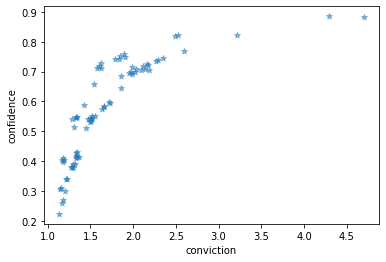

In [82]:
import random
import matplotlib.pyplot as plt
 
for i in range (len(conviction)):
    conviction[i] = conviction[i] + 0.0025 * (random.randint(1,10) - 5) 
    confidence[i] = confidence[i] + 0.0025 * (random.randint(1,10) - 5)
plt.scatter(conviction, confidence,   alpha=0.5, marker="*")
#plt.plot(conviction, np.poly1d(np.polyfit(conviction, confidence, 1))(conviction),'r')
plt.xlabel('conviction')
plt.ylabel('confidence') 
plt.show()
#https://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list

### Antecedent Support and Leverage

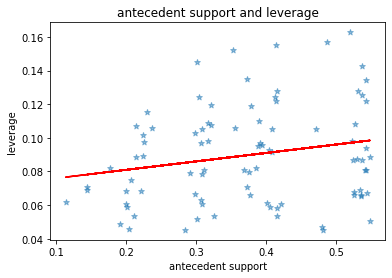

In [88]:
import random
import matplotlib.pyplot as plt
 
for i in range (len(antecedent_support)):
    antecedent_support[i] = antecedent_support[i] + 0.0025 * (random.randint(1,10) - 5) 
    leverage[i] = leverage[i] + 0.0025 * (random.randint(1,10) - 5)
plt.scatter(antecedent_support, leverage,   alpha=0.5, marker="*")
plt.plot(antecedent_support, np.poly1d(np.polyfit(antecedent_support, leverage, 1))(antecedent_support),'r')
plt.xlabel('antecedent support')
plt.ylabel('leverage') 
plt.title('antecedent support and leverage')
plt.show()

### Consequent support and Leverage

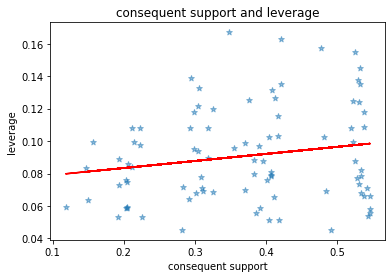

In [90]:
import random
import matplotlib.pyplot as plt
 
for i in range (len(consequent_support)):
    consequent_support[i] = consequent_support[i] + 0.0025 * (random.randint(1,10) - 5) 
    leverage[i] = leverage[i] + 0.0025 * (random.randint(1,10) - 5)
plt.scatter(consequent_support, leverage,   alpha=0.5, marker="*")
plt.plot(consequent_support, np.poly1d(np.polyfit(consequent_support, leverage, 1))(consequent_support),'r')
plt.xlabel('consequent support')
plt.ylabel('leverage') 
plt.title('consequent support and leverage')
plt.show()